## Single-output 20 class classification with synthetic dataset

In [1]:
from torch import Tensor
### import Necessary packages
import sys
sys.path.append('/Users/jiangxiaoyu/Desktop/All Projects/GPLVM_project_code/')
from models_.lvmogp_svi import LVMOGP_SVI
from models_.variational_elbo import ClfVariationalELBO
from models_.momc_ar_likelihood import Multi_Output_Multi_Class_AR_Likelihood
import torch
from torch.optim.lr_scheduler import StepLR, CyclicLR
from tqdm import trange
import random
import numpy as np
import time
from util_functions import *
from typing import List, Dict
from sklearn.metrics import precision_score, recall_score, f1_score


In [2]:
### Copy from chunchao's code...
from sklearn.datasets import make_classification as mc

X1, Y1 = mc(n_samples=2000, n_classes=20, n_features=5, n_redundant=0, n_informative=5, n_clusters_per_class=1,
                    random_state=1)
X = X1.copy()
Y = Y1[:, None].copy()

In [3]:
train_test_split = 1300
X_train, X_test = Tensor(X[:train_test_split]), Tensor(X[train_test_split:])
Y_train, Y_test = Tensor(Y[:train_test_split]), Tensor(Y[train_test_split:])

In [4]:
print('The number of classes:', Y.max() - Y.min() + 1)
print('The number of train data samples:' , X_train.shape[0])
print('The number of test data samples:' , X_test.shape[0])
print('The number of features:', X_train.shape[-1])

The number of classes: 20
The number of train data samples: 1300
The number of test data samples: 700
The number of features: 5


In [5]:
# Define hyperparameters

clf_list = [20]
# NOTE
# len(clf_list) the total number of outputs
# clf_list[i] the number of classes for (i+1)th output
n_outputs = len(clf_list) # =1 in this ipynb file, only one output
n_latent = int(Tensor(clf_list).sum()) # NOTE n_outputs != n_latent for general cases
n_inputs = int(X_train.shape[0])
index_dim = X_train.shape[-1] # this is 5
latent_dim = 2
n_inducing_inputs = 10
n_inducing_latent = 3
pca = False # Think carefully when setting this to True
n_total= n_outputs * n_inputs

# Model Training Related Hyper-parameters ... 
n_train_iterations = 200 # 1000
learning_rate = 0.5
schduler_step_size = 50
schduler_gamma = 0.9
num_latent_MC = 3

num_class_per_output = 10
num_input_samples = 300

In [6]:
# Specify model, likelihood and training objective.
my_model = LVMOGP_SVI(n_X=n_latent, n_C=n_inputs, index_dim=index_dim, latent_dim=latent_dim, n_inducing_C=n_inducing_inputs, n_inducing_X=n_inducing_latent, data_Y=None, pca=pca)
likelihood = Multi_Output_Multi_Class_AR_Likelihood(clf_list)
mll = ClfVariationalELBO(likelihood, my_model, num_data=n_total)

# Optimizer and Scheduler
optimizer = torch.optim.Adam([ # TODO: tune the choice of optimizer: SGD...
    {'params': my_model.parameters()}], lr=learning_rate)

# scheduler = CyclicLR(optimizer, base_lr=0.01, max_lr=0.5, step_size_up=20, mode='triangular', cycle_momentum=False)
scheduler = StepLR(optimizer, step_size=schduler_step_size, gamma=schduler_gamma)

## Initialization

In [7]:
for name, param in my_model.named_parameters():
    print(name, param.size())

variational_strategy.inducing_points_X torch.Size([3, 2])
variational_strategy.inducing_points_C torch.Size([10, 5])
variational_strategy._variational_distribution.variational_mean torch.Size([30])
variational_strategy._variational_distribution.chol_variational_covar_X torch.Size([3, 3])
variational_strategy._variational_distribution.chol_variational_covar_C torch.Size([10, 10])
X.q_mu torch.Size([20, 2])
X.q_log_sigma torch.Size([20, 2])
covar_module_X.raw_outputscale torch.Size([])
covar_module_X.base_kernel.raw_lengthscale torch.Size([1, 2])
covar_module_C.raw_outputscale torch.Size([])
covar_module_C.base_kernel.raw_lengthscale torch.Size([1, 5])


In [8]:
print('have a look at pre-trained model parameters ... ')

# print('inducing_points_X', my_model.variational_strategy.inducing_points_X.detach())
# print('inducing_points_C', my_model.variational_strategy.inducing_points_C.detach())
# print('X q_mu', my_model.X.q_mu.detach())
# print('X q_sigma', my_model.X.q_log_sigma.detach().exp()**2)
# print('variational mean', my_model.variational_strategy._variational_distribution.variational_mean.detach())
# print('variational chol X', my_model.variational_strategy._variational_distribution.chol_variational_covar_X.detach())
# print('variational chol C', my_model.variational_strategy._variational_distribution.chol_variational_covar_C.detach())
# print('covar_module_X outputscale', my_model.covar_module_X.outputscale.detach())
# print('covar_module_X base_kernel lengthscale', my_model.covar_module_X.base_kernel.lengthscale.detach())
# print('covar_module_C outputscale', my_model.covar_module_C.outputscale.detach())
# print('covar_module_C base_kernel lengthscale', my_model.covar_module_C.base_kernel.lengthscale.detach())

have a look at pre-trained model parameters ... 


In [9]:
'''
# Randomly pick samples in X_train as initialization of inducing_points_C in my_model ... 
random_idx = torch.randint(0, n_inputs, (n_inducing_inputs,))
my_model.variational_strategy.inducing_points_C.data = X_train[random_idx]

# print(my_model.covar_module_C.raw_outputscale.requires_grad)
'''

'\n# Randomly pick samples in X_train as initialization of inducing_points_C in my_model ... \nrandom_idx = torch.randint(0, n_inputs, (n_inducing_inputs,))\nmy_model.variational_strategy.inducing_points_C.data = X_train[random_idx]\n\n# print(my_model.covar_module_C.raw_outputscale.requires_grad)\n'

## Training

In [10]:
# Training!
loss_list = []
iterator = trange(n_train_iterations, leave=True)

my_model.train()
for i in iterator: 
    batch_index_latent, batch_index_inputs = clf_sample_f_index_everyoutput(my_model, clf_list, Y_train, num_class_per_output=num_class_per_output, num_input_samples=num_input_samples)
    # core code is here 
    optimizer.zero_grad()
    total_loss = 0
    for _ in range(num_latent_MC):
        sample_latent = my_model.sample_latent_variable(batch_index_latent) 
        sample_inputs = X_train[batch_index_inputs]
        output_batch = my_model(sample_latent.reshape(-1,latent_dim), sample_inputs.reshape(-1,index_dim)) # q(f)
        loss = -mll(output_batch, ref=batch_index_latent)
        total_loss += loss
    
    average_loss = total_loss / num_latent_MC
    loss_list.append(average_loss.item())
    iterator.set_description('Loss: ' + str(float(np.round(average_loss.item(),2))) + ", iter no: " + str(i))
    average_loss.backward()
        
    # Gradient Clipping. Try Many Different Approaches.
    gradient_clip(my_model, approach='Global Norm Clipping', clip_value=5)
    # gradient_clip(likelihood, clip_value=1)
    
    optimizer.step()
    scheduler.step()

Loss: 0.34, iter no: 199: 100%|██████████| 200/200 [04:50<00:00,  1.45s/it]


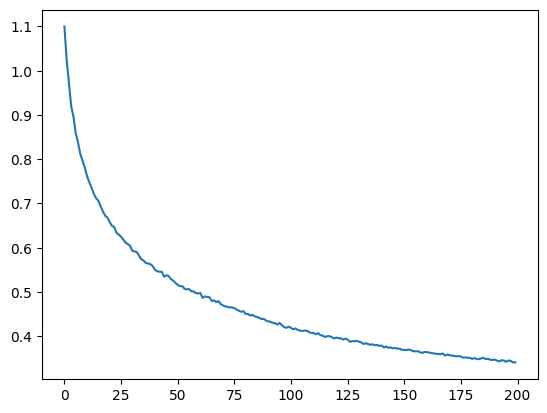

In [11]:
import matplotlib.pyplot as plt

plt.plot(loss_list)

In [12]:
# print(' have a look at after-trained model parameters ... ')

# print('inducing_points_X', my_model.variational_strategy.inducing_points_X.detach())
# print('inducing_points_C', my_model.variational_strategy.inducing_points_C.detach())
# print('X q_mu', my_model.X.q_mu.detach())
# print('X q_sigma', my_model.X.q_log_sigma.detach().exp()**2)
# print('variational mean', my_model.variational_strategy._variational_distribution.variational_mean.detach())
# print('variational chol X', my_model.variational_strategy._variational_distribution.chol_variational_covar_X.detach())
# print('variational chol C', my_model.variational_strategy._variational_distribution.chol_variational_covar_C.detach())
# print('covar_module_X outputscale', my_model.covar_module_X.outputscale.detach())
# print('covar_module_X base_kernel lengthscale', my_model.covar_module_X.base_kernel.lengthscale.detach())
# print('covar_module_C outputscale', my_model.covar_module_C.outputscale.detach())
# print('covar_module_C base_kernel lengthscale', my_model.covar_module_C.base_kernel.lengthscale.detach())

## Testing

In [13]:
# my_model.X.q_mu.detach()
# my_model.X.q_log_sigma.detach().exp()

In [14]:
'''
for name, param in my_model.named_parameters():
    if 'variational_strategy.inducing' in name:
        print(name, param.size())
        print(param)
'''

"\nfor name, param in my_model.named_parameters():\n    if 'variational_strategy.inducing' in name:\n        print(name, param.size())\n        print(param)\n"

In [15]:
all_outputs_prob_mean, all_outputs_prob_var, all_outputs_decisions, all_outputs_decisions_var = MOMOC_predict(my_model, X_train, clf_list)

In [16]:
(1.0 * (all_outputs_decisions == Y_train)).mean()

tensor(0.0485)

In [17]:
eval_results = MOMC_classification_eval(all_outputs_decisions, Y_train)

In [18]:
eval_results

{'Precision_Weighted': [0.04842419091652776],
 'Recall_Weighted': [0.04846153846153846],
 'F1_Weighted': [0.048221101569761934]}